# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to C:\Users\Khushi
[nltk_data]     Gajjar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Exploratory Data Analysis

In [5]:
#Load the data

data = pd.read_csv(r"D:\AI Project\Data\dataset_ai.csv")

print(f"Dataset shape : {data.shape}")

Dataset shape : (1000, 4)


In [6]:
data.head()

,rating,date,reviews,feedback
0,5.0,30-Jul-18,"Love it, we are still learning the capabilitie...",1.0
1,5.0,29-Jul-18,Very easy setup.,1.0
2,5.0,17-Jul-18,,1.0
3,5.0,26-Jul-18,I purchased this on prime day mostly as a pres...,1.0
4,5.0,30-Jul-18,Fun and information. No dislikes so far !! ...,1.0


In [7]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'date' 'reviews' 'feedback']


In [8]:
#Check for null values

data.isnull().sum()

rating      1
date        0
reviews     0
feedback    1
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [9]:
#Getting the record where 'verified_reviews' is null 

data[data['reviews'].isna() == True]

,rating,date,reviews,feedback


In [10]:
#We will drop the null record

data.dropna(inplace=True)

In [11]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (998, 4)


In [12]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['reviews'].apply(len)

In [13]:
data.head()

,rating,date,reviews,feedback,length
0,5.0,30-Jul-18,"Love it, we are still learning the capabilitie...",1.0,69
1,5.0,29-Jul-18,Very easy setup.,1.0,16
2,5.0,17-Jul-18,,1.0,1
3,5.0,26-Jul-18,I purchased this on prime day mostly as a pres...,1.0,727
4,5.0,30-Jul-18,Fun and information. No dislikes so far !! ...,1.0,68


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [14]:
#Randomly checking for 10th record

print(f"'reviews' column value: {data.iloc[15]['reviews']}") #Original value
print(f"Length of review : {len(data.iloc[15]['reviews'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[15]['length']}") #Value of the column 'length'

'reviews' column value: I didn't like that almost everytime i asked Alexa a question she would say i dont know that or i havent learned that.
Length of review : 117
'length' column value : 117


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [15]:
data.dtypes

rating      float64
date         object
reviews      object
feedback    float64
length        int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [16]:

len(data)

998

In [17]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5.0    715
4.0    144
3.0     49
1.0     48
2.0     42
Name: count, dtype: int64


Let's plot the above values in a bar graph

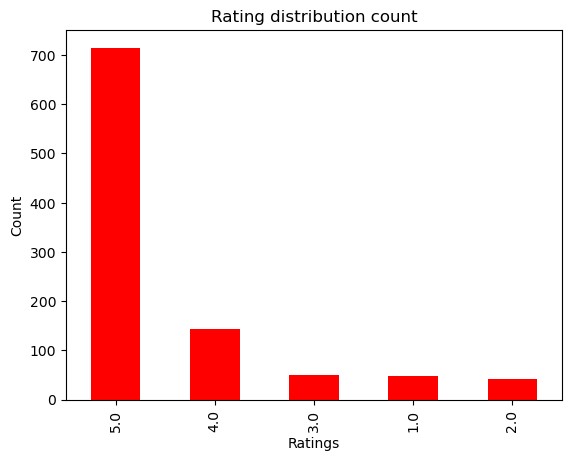

In [18]:
#Bar plot to visualize the total counts of each rating

data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [19]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5.0    71.64
4.0    14.43
3.0     4.91
1.0     4.81
2.0     4.21
Name: count, dtype: float64


### Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [20]:
#Distinct values of 'feedback' and its count 

print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1.0    908
0.0     90
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [21]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback'] == 0].iloc[1]['reviews']
print(review_0)

Thought it would be more powerful and have a lot more functionality. Not much better than the Echo dot. Not worth the money.


In [22]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback'] == 1].iloc[1]['reviews']
print(review_1)

Very easy setup.


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

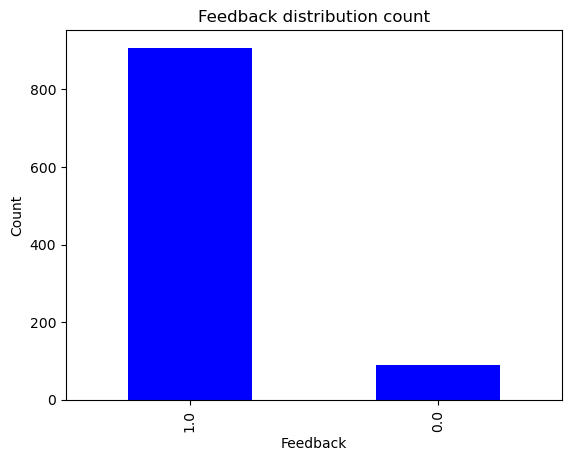

In [23]:
#Bar graph to visualize the total counts of each feedback

data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [24]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1.0    90.98
0.0     9.02
Name: count, dtype: float64


Feedback distribution <br>
* 91.87% reviews are positive <br>
* 8.13% reviews are negative

Let's see the 'rating' values for different values of 'feedback'

In [25]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1.0    48
2.0    42
Name: count, dtype: int64

In [26]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5.0    715
4.0    144
3.0     49
Name: count, dtype: int64

##### If rating of a review is 1 or 2 then the feedback is 0 (negative) and if the rating is 3, 4 or 5 then the feedback is 1 (positive).

### Analyzing 'verified_reviews' column

This column contains the textual review given by the user for a variation for the product.

In [27]:
data['length'].describe()

count     998.000000
mean      123.613226
std       160.364275
min         1.000000
25%        32.000000
50%        74.500000
75%       154.000000
max      2393.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

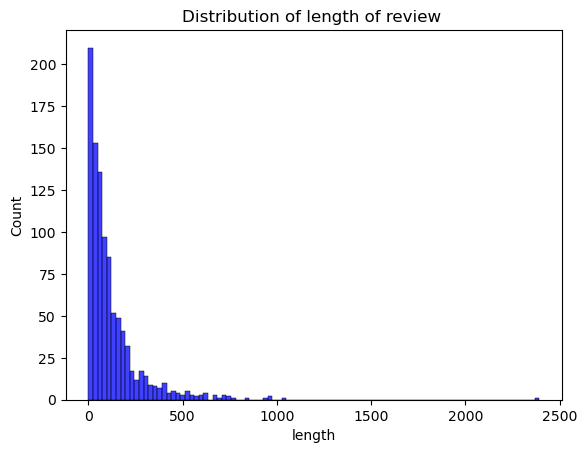

In [28]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

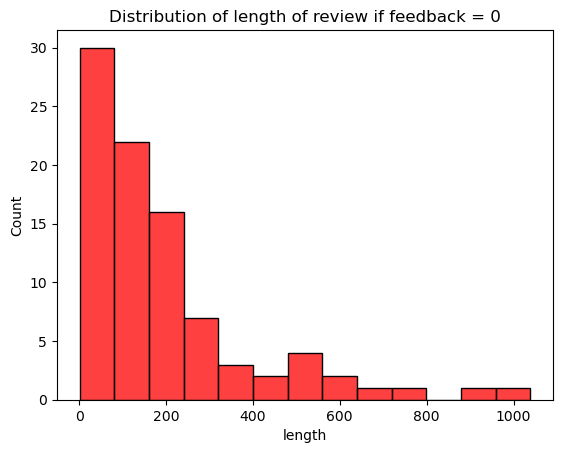

In [29]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

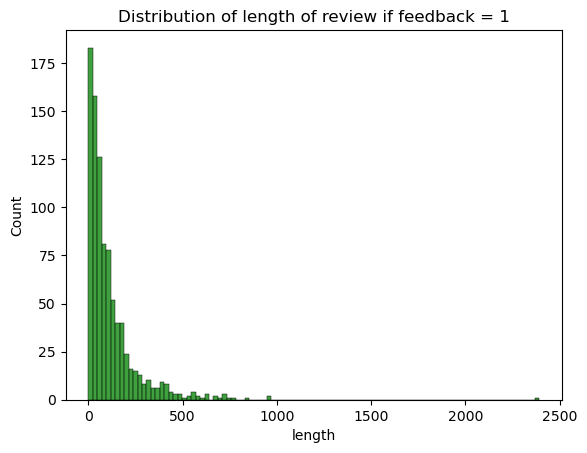

In [30]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

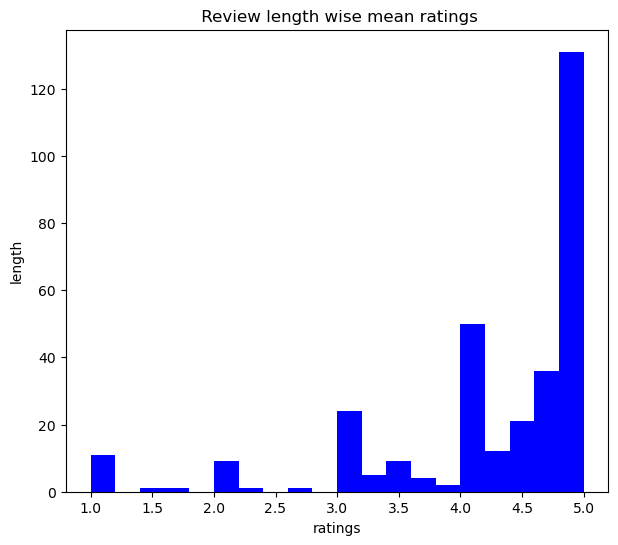

In [31]:
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [32]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.reviews)

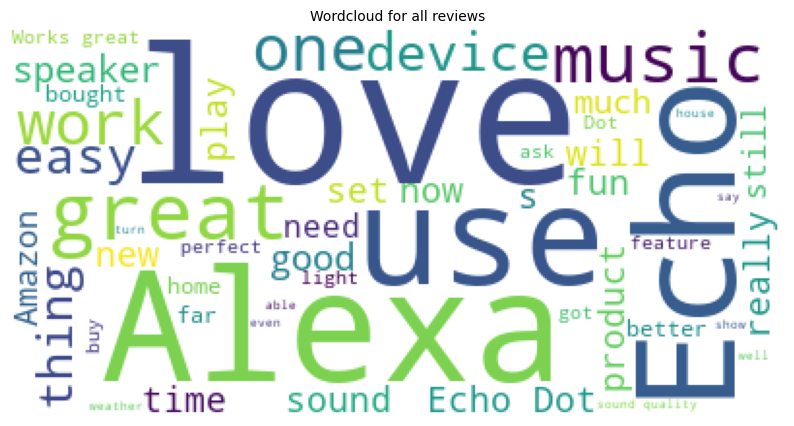

In [33]:
# Combine all reviews
reviews = " ".join([review for review in data['reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [34]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


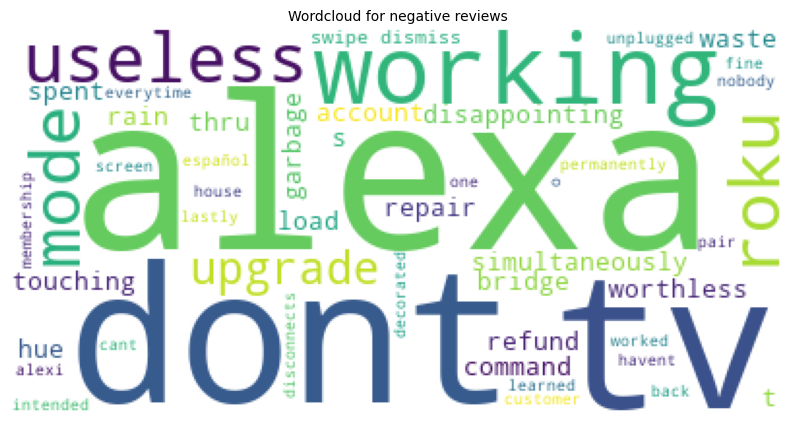

In [35]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - garbage, pointless, poor, horrible, repair etc

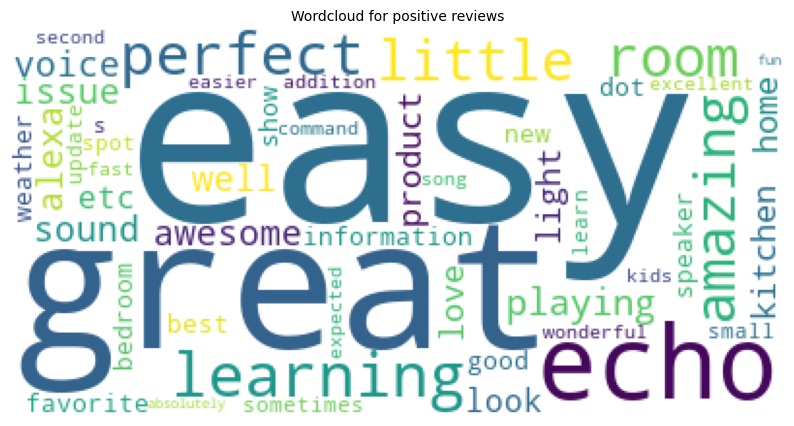

In [36]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, enjoying, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [37]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [38]:
corpus

['love still learn capabl lot fun',
 'easi setup',
 '',
 'purchas prime day mostli present found echo plu kitchen counter overwhelm cook cut clean etc especi counter wide begin go back forth show decid felt featur compact honestli say regret probabl watch movi die see great way listen music watch quick youtub video etc even attempt watch jaw comfort thing eye bad one would think would definit recommend',
 'fun inform dislik far like conveni',
 'pleas fire stick',
 'love great bathroom listen news shower listen cnn live seriu sm',
 'speaker loud googl home',
 'echo dot relat devic best thing come long time',
 'easi use great recip listen music see movi movi trailer much',
 'la pel cula tien se pueden cambiar espa ol tulo en espa ol',
 'thought would power lot function much better echo dot worth money',
 'work advertis thank',
 'easi set use bought two one hous one year old grandfath set gave minut lesson call least day great abl see visit',
 'still love',
 'like almost everytim ask alex

Using Count Vectorizer to create bag of words

In [39]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [40]:
#Saving the Count Vectorizer
pickle.dump(cv, open('D:\\AI Project\\countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [41]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (998, 1628)
y shape: (998,)


Splitting data into train and test set with 30% data with testing.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (698, 1628)
y train: (698,)
X test: (300, 1628)
y test: (300,)


In [43]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 6
X test max value: 6


We'll scale X_train and X_test so that all values are between 0 and 1.

In [44]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [45]:
#Saving the scaler model
pickle.dump(scaler, open('D:\\AI Project\\scaler.pkl', 'wb'))

#### Random Forest

In [46]:


# Assuming X_train and y_train are your training data
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

# Serialize the model
with open("D://AI Project//Model//model_rf.pkl", 'wb') as f:
    pickle.dump(model_rf, f)


In [47]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.994269340974212
Testing Accuracy : 0.9133333333333333


In [48]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [49]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

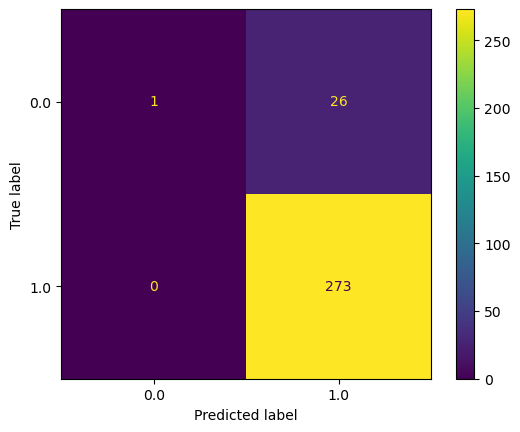

In [50]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [51]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9183643892339545
Standard Variance : 0.011032321845550364


Applying grid search to get the optimal parameters on random forest

In [52]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [53]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [54]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [55]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.90186246418338
Cross validation mean accuracy on test set : 90.97421203438395
Accuracy score for test set : 0.9133333333333333


#### XgBoost

In [56]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

# Serialize the model
with open("D://AI Project//Model//model_xgb.pkl", 'wb') as f:
    pickle.dump(model_xgb, f)

In [57]:
y_preds = model_xgb.predict(X_test)

In [58]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  4  23]
 [ 10 263]]


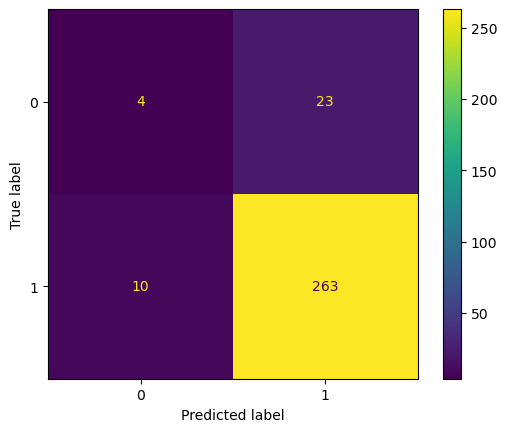

In [59]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [60]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('D:\\AI Project\\model_xgb.pkl', 'wb'))

#### Decision Tree Classifier

In [61]:
#Accuracy of the model on training and testing data


model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.994269340974212
Testing Accuracy : 0.8666666666666667


In [62]:
y_preds = model_dt.predict(X_test)

In [63]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[  6  21]
 [ 25 248]]


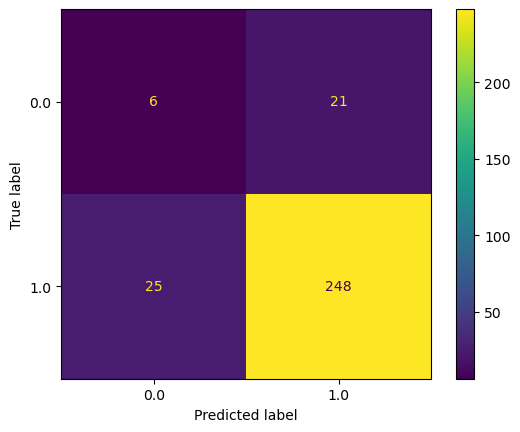

In [64]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, mask_zero=True))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test_scl, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/10


C:\Users\Khushi Gajjar\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:847: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8375 - loss: 0.5652 - val_accuracy: 0.9100 - val_loss: 0.3053
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9085 - loss: 0.3252 - val_accuracy: 0.9100 - val_loss: 0.3109
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9251 - loss: 0.2801 - val_accuracy: 0.9100 - val_loss: 0.3041
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9113 - loss: 0.3131 - val_accuracy: 0.9100 - val_loss: 0.3041
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9092 - loss: 0.3276 - val_accuracy: 0.9100 - val_loss: 0.3032
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9216 - loss: 0.2858 - val_accuracy: 0.9100 - val_loss: 0.3027
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9028 - loss: 0.3313 - val_accuracy: 0.9100 - val_loss: 0.3027
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9143 - loss: 0.3018 - val_accuracy: 0.9100 - val_loss: 0.3064
Epo

In [68]:
import keras
keras.saving.save_model(model, 'my_model.keras')